<a href="https://colab.research.google.com/github/OrionXV/WeirdProject/blob/Ishaan/plotfitterClassDocumentedISHAANFIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
#Dependencies
import astropy.convolution.convolve as conv
from astropy.convolution import Box1DKernel as box1d
from astropy.convolution import Gaussian1DKernel as g1d
from astropy.table import Table
import pandas as pd
from matplotlib.pyplot import figure
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import math 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.optimize import leastsq
from scipy.special import erf
%config InLineBackend.figure_format = 'retina'

class Curve_Fitter():
    #data_path to initialize the dataframe which we will work on. Only required parameter.
    def __init__(self, data_path, convo_size = 60):
        self.data_raw = Table.read(data_path).to_pandas()
        self.data = self.convolve(self.data_raw, convo_size)#we will use convolved data for most of our purposes
        self.peak_list,_=find_peaks(self.data['RATE'], height= 50,distance=60)  
        self.width=peak_widths(self.data['RATE'],self.peak_list,rel_height=0.97)
        self.start=self.width[2].astype(int)
        self.stop=self.width[3].astype(int)
        self.bdraw,self.bdata=self.bgdata()
        self.std=self.datastd()
        self.newcurve=self.peak_fitter()
        
        
        
                  

    #function to convovle the data, returns a new dataframe
    def convolve(self, data, width):
        data2 = data.copy()
        data2['RATE'] = conv(np.array(data['RATE']), kernel = g1d(width), boundary = 'extend')
        return data2
    
    #MATHS AHEAD
    #Z = (2*B + (C**2)*D)/(2*C)
    #Just a temp function so we don't have to write the expression again and again
    def z_func(self, B, C, D):
        return (2*B + (C**2)*D)/(2*C)
    
    #Our objective function, we will fit our curve over this
    def objective_func(self, T, A, B, C, D, E, F):
        return math.sqrt(np.pi*0.5)*A*C*np.exp(D/2*((2*B)+(C**2)*(D/2)-(2*(T*E+ F))))*(erf(self.z_func(B, C, D))- erf(self.z_func(B, C, D) - (T*E+ F)/C))

    #Defining the cost function. We will use sqrt(chi) for our calculations   
    def objective_cost_func(self, params, x, y):
        a0, b0, c0, d0, e0, f0 = params[0], params[1], params[2], params[3], params[4], params[5]
        return np.sqrt(((y - self.objective_func(x, a0, b0, c0, d0, e0, f0))**2)/y)

    #Sclaing functions
    def min_max_scaler(self, df):
        df['RATESCALED'] = (df['RATE']- df['RATE'].min())/(df['RATE'].max()- df['RATE'].min())
        df['TIMESCALED'] = (df['TIME']- df['TIME'].min())/(df['TIME'].max()- df['TIME'].min())*2

    def rev_scaler(self, df, x):
        return x*(df['RATE'].max()- df['RATE'].min()) + df['RATE'].min()
    
   
    def bgdata(self):
        c=self.data.copy()
        remove=[]
        for i in range(len(self.start)):
          remove+=np.arange(self.start[i],self.stop[i],1).tolist()
        remove=list(set(remove))
        rawbg=self.data_raw.drop(remove)
        return rawbg,np.mean(c.drop(remove)['RATE'])
    
    def datastd(self):
        zerodata=self.bdraw['RATE']-self.bdata
        return np.std(zerodata)
  

    def peak_fitter(self):
        self.min_max_scaler(self.data)
        peak_data_list = []
        peak_df_list = []
        input=[]
        scaledcurve=[]
        newcurve=[]
        
        for i in range(len(self.peak_list)):

            TIME = self.data['TIME'][self.start[i]:self.stop[i]] - self.data['TIME'][self.start[i]] #Some scaling
            RATE = self.data['RATESCALED'][self.start[i]:self.stop[i]]

            params = [0.2, 0.3, 0.3, 0.4, 0.1, 0.1] #Rando params 

            resultsq = leastsq(self.objective_cost_func, params, (TIME, RATE))
            a, b, c, d, e, f = resultsq[0][0], resultsq[0][1], resultsq[0][2], resultsq[0][3], resultsq[0][4], resultsq[0][5]
            input_time=np.arange(-10000,list(TIME)[-1]+10000,1)
            new_curve=self.objective_func(input_time, a, b, c, d, e, f)
            input=(self.data['TIME'][self.start[i]]+input_time)
            scaledcurve=(self.rev_scaler(self.data, new_curve))
            newcurve.append(pd.DataFrame({'TIME':input,'RATE':scaledcurve}))
        return newcurve

  
    def startidx(self):
      start=[]
      end=[]
      newcurve=self.peak_fitter()
      for i in range(len(self.peak_list)):
        sloc=self.newcurve[i][self.newcurve[i]['RATE']>=self.bdata+self.std].index.tolist()[0]
        eloc=self.newcurve[i][self.newcurve[i]['RATE']>=self.bdata+self.std].index.tolist()[-1]
        start.append(newcurve[i]['TIME'][sloc])
        end.append(newcurve[i]['TIME'][eloc])
      return start,end


    def params(self):
      start,end=self.startidx()

      df=pd.DataFrame(columns=['decay_time','rise_time','peak_flux'])
      for i in range(len(self.peak_list)):
        df=df.append({'decay_time':end[i]-self.data['TIME'][self.peak_list[i]],
                   'rise_time':self.data['TIME'][self.peak_list[i]]-start[i],
                    'peak_flux':self.data['RATE'][self.peak_list[i]]},ignore_index=True)
      return df
   




    #Plots our data, if you have already called fitter, then pass the params in here. 
    
            

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS" -O lc.zip && rm -rf /tmp/cookies.txt

--2022-03-15 18:30:40--  https://docs.google.com/uc?export=download&confirm=t&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS
Resolving docs.google.com (docs.google.com)... 142.250.73.238, 2607:f8b0:4004:82a::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mqftf3q9njo6hk33dld95un0g4htsk40/1647369000000/04989237414475792611/*/1bRy8RDtWz5hbOn888XHSO3QToUAYCctS?e=download [following]
--2022-03-15 18:30:40--  https://doc-14-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mqftf3q9njo6hk33dld95un0g4htsk40/1647369000000/04989237414475792611/*/1bRy8RDtWz5hbOn888XHSO3QToUAYCctS?e=download
Resolving doc-14-a0-docs.googleusercontent.com (doc-14-a0-docs.googleusercontent.com)... 172.217.1.193, 2607:f8b0:4004:801::2001
Connecting to doc-14-a0-docs.googleusercontent.com (doc-14-a0-docs.goog

In [6]:
!unzip -q lc.zip

In [55]:

file = Curve_Fitter(data_path = '/content/lc/ch2_xsm_20200409_v1_level2.lc')

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


In [56]:
p=file.params()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


In [57]:
p

,decay_time,rise_time,peak_flux
0,1285.0,282.0,57.992809
1,5634.0,471.0,274.894531
2,10866.0,2366.0,313.795746
3,925.0,698.0,57.301216


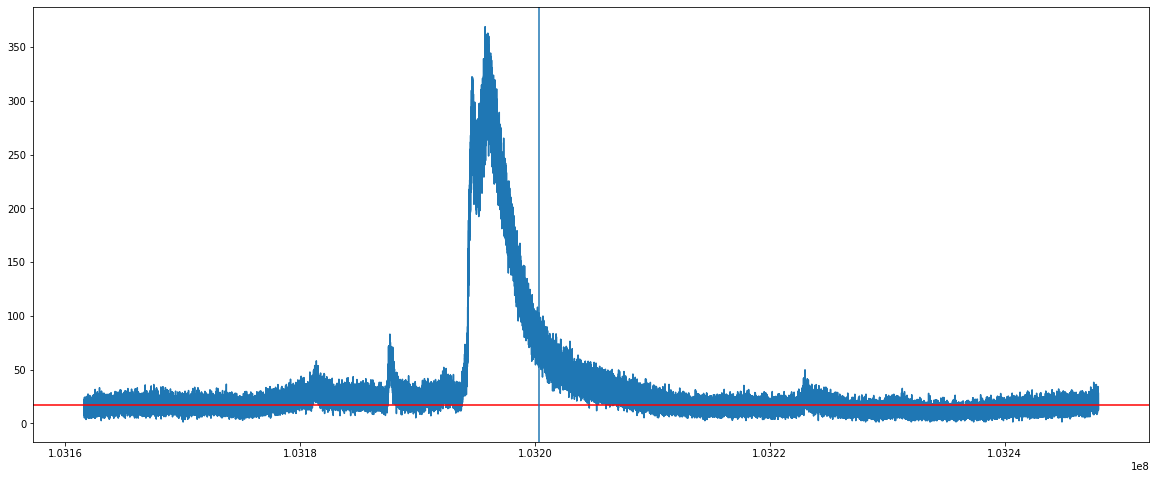

In [18]:
plt.figure(figsize=(20,8))
plt.plot(file.data_raw['TIME'],file.data_raw['RATE'])

plt.axhline(file.bdata,color='r')
plt.axhline(file.bdata+file.std,color='g')
#lt.plot(file.input[1],file.scaledcurve[1],color='red')
#lt.plot(file.input[2],file.scaledcurve[2],color='cyan')
plt.axvline(p[1][1])


In [72]:
file.stop

array([24765, 32160, 69894, 77662, 79509])

In [75]:
file.c

[20270,
 20271,
 20272,
 20273,
 20274,
 20275,
 20276,
 20277,
 20278,
 20279,
 20280,
 20281,
 20282,
 20283,
 20284,
 20285,
 20286,
 20287,
 20288,
 20289,
 20290,
 20291,
 20292,
 20293,
 20294,
 20295,
 20296,
 20297,
 20298,
 20299,
 20300,
 20301,
 20302,
 20303,
 20304,
 20305,
 20306,
 20307,
 20308,
 20309,
 20310,
 20311,
 20312,
 20313,
 20314,
 20315,
 20316,
 20317,
 20318,
 20319,
 20320,
 20321,
 20322,
 20323,
 20324,
 20325,
 20326,
 20327,
 20328,
 20329,
 20330,
 20331,
 20332,
 20333,
 20334,
 20335,
 20336,
 20337,
 20338,
 20339,
 20340,
 20341,
 20342,
 20343,
 20344,
 20345,
 20346,
 20347,
 20348,
 20349,
 20350,
 20351,
 20352,
 20353,
 20354,
 20355,
 20356,
 20357,
 20358,
 20359,
 20360,
 20361,
 20362,
 20363,
 20364,
 20365,
 20366,
 20367,
 20368,
 20369,
 20370,
 20371,
 20372,
 20373,
 20374,
 20375,
 20376,
 20377,
 20378,
 20379,
 20380,
 20381,
 20382,
 20383,
 20384,
 20385,
 20386,
 20387,
 20388,
 20389,
 20390,
 20391,
 20392,
 20393,
 20394,


In [13]:
def convolve(data, width):
        data2 = data.copy()
        data2['RATE'] = conv(np.array(data['RATE']), kernel = g1d(width), boundary = 'extend')
        return data2

In [16]:
data1=convolve(file.data_raw,60)

In [19]:
def plot_portion(data):
  if type(data) is list :
     for i in data:
         plt.plot(i['TIME'],i['RATE'])
  else:
     plt.plot(data['TIME'],data['RATE'])



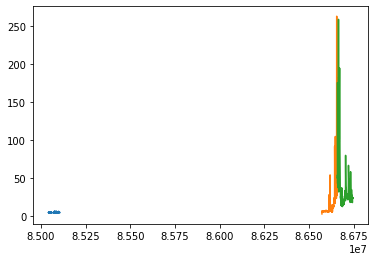

In [25]:
data2=convolve(file.data_raw,60000)

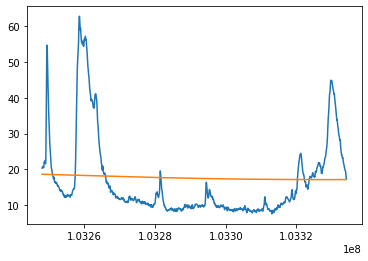

In [34]:
e=p[0]['curve_params'][3:5]

In [ ]:
f=p[0]['']

In [35]:
plt.plot(d)

[0.23053161237985498, 0.005035550960015443]

In [36]:
f=p[1]['curve_params'][3:5]
f

[0.01172585544023434, 0.029504842516117742]

In [7]:
lc=pd.DataFrame({'time':[1,2,3,4,4,66,7,7,8],'rate':[1,2,3,4,5,6,7,8,9]})

In [78]:
def bgdata(data,peakwidth):
    return data.drop(peakwidth[0]+np.array(range(peakwidth[1]-peakwidth[0])))
    

In [ ]:
def datastd(bddata,rawdata):
  zerodata=rawdata['RATE']-bddata['RATE']
  return np.std(zerodata['RATE'])
def start_end(bgdata,datastd,dat,peaks,width):
  rangetocheck=data[data['RATE']==bgdata+datastd].tolist()
  start,end=startidx(rangetocheck,peaks,width)
  
def startidx(rangetocheck,peaks,width):
  start=[]
  end=[]
  for i in range(len(peaks)):
    p=math.abs(rangetocheck-peaks[i])
    q=p.index(min(p))

    if rangetocheck[q]>i:
      if q==0:
         end.append(rangetocheck[q])
         start.append(width[2][i])
      else:
         start.append(rangetocheck[q-1])
         end.append(rangetocheck[q])

    else:
       if q==len(rangetocheck):
         end.append(width[3][iter])
         start.append(rangetocheck[q])
       else:
         start.append(rangetocheck[q])
         end.append(rangetocheck[q+1])
  return start,end



  

  



In [19]:

p=lc.index[lc['rate']>6].tolist()


In [20]:
p

[6, 7, 8]